In [24]:
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
from typing_extensions import Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

In [3]:
load_dotenv()

llm = ChatOpenAI(model = 'gpt-4o-mini')

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [35]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def human_evaluator(state: State):
    """Human evaluates the joke"""
    print(f'[Human Evaluator] Joke: "{state["joke"]}" \n')
    human_response = interrupt('Is the Joke funny? \n Reply with "funny" or "not funny".\n')
    print(f'[Human Evaluator] Human response recorded : "{human_response}"')
    return {"funny_or_not": human_response, "feedback": ''}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    print(f'[LLM Evaluator] Is the joke funny? : "{grade.grade}"')
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"].lower() == "funny":
        return "Accepted"
    elif state["funny_or_not"].lower() == "not funny":
        return "Rejected + Feedback"

In [36]:
def build_workflow(human_in_loop: bool = False) -> StateGraph:
    # Build workflow
    optimizer_builder = StateGraph(State)

    # Add the nodes
    optimizer_builder.add_node("llm_call_generator", llm_call_generator)
    optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)
    optimizer_builder.add_node(
        "human_evaluator", human_evaluator
    )

    # Add edges to connect nodes
    optimizer_builder.add_edge(START, "llm_call_generator")
    if human_in_loop:
        optimizer_builder.add_edge("llm_call_generator", "human_evaluator")
        optimizer_builder.add_conditional_edges(
            "human_evaluator",
            route_joke,
            {  # Name returned by route_joke : Name of next node to visit
                "Accepted": END,
                "Rejected + Feedback": "llm_call_generator",
            },
        )
    else:
        optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
        optimizer_builder.add_conditional_edges(
            "llm_call_evaluator",
            route_joke,
            {  # Name returned by route_joke : Name of next node to visit
                "Accepted": END,
                "Rejected + Feedback": "llm_call_generator",
            },
        )

    return optimizer_builder

In [ ]:
# Set up memory
memory = InMemorySaver()
optimizer_workflow = build_workflow(human_in_loop=True)
app = optimizer_workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}
response = app.invoke({"topic": "Nerds"}, config=config)
print(response['__interrupt__'][0])

In [ ]:
response = app.invoke(Command(resume="not funny"), config=config)

print(response)

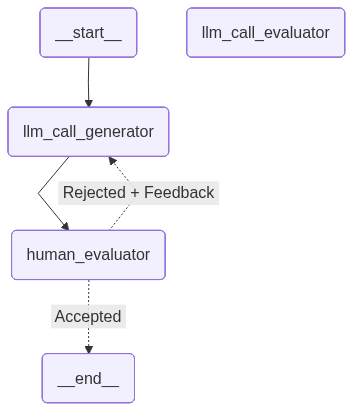

In [52]:
# Show the workflow
display(Image(app.get_graph().draw_mermaid_png()))